In [173]:
from ipywidgets import widgets
from IPython.display import display, display_svg, clear_output
from globus_automate_client import create_flows_client, graphviz_format, state_colors_for_log
import json
import time
import pandas as pd

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  


CLIENT_ID = "e6c75d97-532a-4c88-b031-8584a319fa3e"
fc = create_flows_client(CLIENT_ID)

I know the flow ID that I have been running, so let's start there

In [174]:
# Select an id from one of the flows above to continue exploring and running
flow_id = '16bef6f8-70b4-4e10-b203-b31d8486af15'

Make sure this is right and has the correct steps:

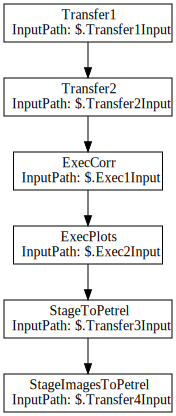

In [175]:
get_resp = fc.get_flow(flow_id)
flow_def = get_resp.data['definition']
flow_graph = graphviz_format(flow_def)
display(flow_graph)

I need the flow scope to inspect these calls:

In [183]:
flow_scope = 'https://auth.globus.org/scopes/16bef6f8-70b4-4e10-b203-b31d8486af15/flow_16bef6f8_70b4_4e10_b203_b31d8486af15'

List out the invocations of this flow

In [177]:
flow_runs = fc.list_flow_actions(flow_id, flow_scope, statuses=None)

Check one of them to see what it looks like.

In [178]:
# print(len(flow_runs['actions']))
print(flow_runs['actions'][0])

{'action_id': 'eecff227-a692-4fdd-835d-77595fd4e5e7', 'completion_time': 'None', 'created_by': 'urn:globus:auth:identity:c4765424-d274-11e5-b894-cb4139f74ecf', 'details': {'code': 'ActionStarted', 'description': 'State Transfer1 of type Action started', 'details': {'input': {'Exec1Input': {'data': {'hdf': '/projects/APSDataAnalysis/Automate/1569244619/A091_SMB_D_BR_June_Homo_SI30_att0_Lq0_001_0001-0512.hdf', 'imm': '/projects/APSDataAnalysis/Automate/1569244619/A091_SMB_D_BR_June_Homo_SI30_att0_Lq0_001_00001-00512.imm'}, 'endpoint': 'ad2fd055-46fb-430c-b872-8c924c03bb83', 'func': 'f9d25f32-c209-4516-bfc4-48d55eb65441'}, 'Exec2Input': {'data': {'hdf': '/projects/APSDataAnalysis/Automate/1569244619/A091_SMB_D_BR_June_Homo_SI30_att0_Lq0_001_0001-0512.hdf'}, 'endpoint': 'ad2fd055-46fb-430c-b872-8c924c03bb83', 'func': '2b69c30e-3c84-42f7-83b7-a3f024f978c9'}, 'Transfer1Input': {'destination_endpoint_id': '08925f04-569f-11e7-bef8-22000b9a448b', 'source_endpoint_id': 'b0e921df-6d04-11e5-ba46-2

In [179]:
action_id = 'eecff227-a692-4fdd-835d-77595fd4e5e7'

Check the action logs for this flow

In [180]:
flow_log = fc.flow_action_log(flow_id, flow_scope, action_id)

In [181]:
flow_log

GlobusHTTPResponse({'entries': [{'code': 'FlowFailed', 'details': {'cause': 'The cause could not be determined because Lambda did not return an error type.'}, 'time': '2019-09-23T13:17:49.110000+00:00'}, {'code': 'ActionFailed', 'details': {'cause': 'The cause could not be determined because Lambda did not return an error type.'}, 'time': '2019-09-23T13:17:49.110000+00:00'}, {'action_url': 'https://actions.automate.globus.org/transfer/transfer', 'code': 'ActionPolled', 'description': 'Polling for completion of action state Transfer1', 'details': {'state_name': 'Transfer1'}, 'time': '2019-09-23T13:17:33.840000+00:00'}, {'action_url': 'https://actions.automate.globus.org/transfer/transfer', 'code': 'ActionPolled', 'description': 'Polling for completion of action state Transfer1', 'details': {'state_name': 'Transfer1'}, 'time': '2019-09-23T13:17:17.563000+00:00'}, {'code': 'ActionFailed', 'details': {'cause': 'qEXSZJAuU8cW'}, 'time': '2019-09-23T13:17:17.555000+00:00'}, {'code': 'ActionSt

Hmm, it doesn't look like this one succeeded.

In [184]:
for l in flow_log['entries']:
    print(l['code'])

FlowFailed
ActionFailed
ActionPolled
ActionPolled
ActionFailed
ActionStarted
FlowStarted


This one failed because I had too many concurrent transfers pending.

# Now grab it all into a dataframe

Iterate through all of them and pull out the successful ones. Then we can make a dataframe from their timestamps to see what they got up to.

In [340]:
flow_runs = fc.list_flow_actions(flow_id, flow_scope, statuses=None)

Grab all of the action ids so we can inspect them.

In [62]:
action_ids = []
for res in flow_runs['actions']:
    action_ids.append(res['action_id'])

Now do get each action id's log. This is time consuming.

In [74]:
flow_logs = {}
for aid in action_ids:
    flow_log = fc.flow_action_log(flow_id, flow_scope, aid, limit=100)
    flow_logs.update({aid: flow_log})
#     break

Filter for successful ones.

In [341]:
succeeded_flows = {}
for x, z in flow_logs.items():
    y = z['entries'][0]['code']
#     print(y)
    if 'Succeeded' in y:
        succeeded_flows[x] = z
#     break

In [342]:
print(len(succeeded_flows))

43


This goes from 220 -> 43. I'll run some more at a slower pace to avoid the failures.

Anyway, let's check what these look like and extract the step info.

In [283]:
import datetime

order = ['Start', 'Transfer1', 'Transfer2', 'ExecCorr', 'ExecPlots', 'StageToPetrel', 'StageImagesToPetrel', 'End']

res = {}
for sf in succeeded_flows:
    tmp = succeeded_flows[sf]
    flow_end = None
    flow_start = float('inf')
    flow_start_time = None
    flow_steps = {}
    for x in tmp['entries']:
        action_timestamp = None
        try:
            action_timestamp = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S.%f+00:00').timestamp()
        except:
            action_timestamp = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S+00:00').timestamp()
        if action_timestamp < flow_start:
            flow_start = action_timestamp
            flow_start_time = action_timestamp
        if x['code'] == "FlowSucceeded":
            flow_end = action_timestamp
        if x['code'] == 'ActionCompleted':
            if 'details' in x and 'state_name' in x['details']:
                action_name = x['details']['state_name']
            action_time = action_timestamp
            flow_steps.update({action_name : action_time})
            # We can pull out transfer times/size here. Do that once this works and we want to include more info.
            
    #         if 'Transfer' in action_name or 'Stage' in action_name:
    #             print(action_name)
    #             print(x['details'])
    #             break
    flow_steps.update({"Start": flow_start, "End": flow_end})
    # Deal with the first transfer not existing due to max actions exceeded
    if 'Transfer1' not in flow_steps:
        flow_steps['Transfer1'] = flow_steps['Start']
    flow_times = [flow_steps['Start'], flow_steps['Transfer1'], flow_steps['Transfer2'], 
                  flow_steps['ExecCorr'], flow_steps['ExecPlots'], flow_steps['StageToPetrel'], 
                  flow_steps['StageImagesToPetrel'], flow_steps['End']]
    res[sf] = flow_times
#     print(flow_steps)
#     break


In [284]:
adf = pd.DataFrame.from_dict(res, orient='columns')
adf

,02229ba8-23fa-45c0-9ad2-4982f7dd1b5d,f0ce795a-e4e4-46fd-a997-1e05df29ed42,44861417-0bad-4ecc-ab8c-d8f8b79786d3,878f060a-1a4b-400b-82c4-d06c45402052,5ed48889-bc13-4ee8-aead-148fd5173921,00ffbb60-2541-45cb-b318-d85c8b8f9e72,b112706d-f406-4e37-bab8-be8c5dcbd7f6,0062ec23-00ed-430e-a7f9-500f93d5628c,410836cf-e59e-413e-8346-6db1d67064c3,81d2f04c-cd3f-4b31-81a7-c140b7ff1b0a,...,d8ebb918-b821-4d6b-aa7e-4056116c7f05,3b77e1a8-3129-4cdf-a71b-f984a5fa000e,7a4ce90d-102c-4e8d-8530-f7eeaf99cd8d,aca32c32-5115-4b26-83e4-12c52080ce54,fe619a38-4f3c-4059-8072-95c06b03bcda,e5890626-0447-4055-ab64-71c69e09ccd1,c5869e76-1afc-44d0-8625-0bea73fdb62d,a4c83500-2502-4a31-b566-2809f98afb58,4fda4148-c372-49d7-9695-38d6c66b37c1,21c3b57e-fe06-4421-ac6a-6ba67b293f4c
0,1.569264e+09,1.569220e+09,1.569221e+09,1.569224e+09,1.569264e+09,1.569224e+09,1.569267e+09,1.569223e+09,1.569216e+09,1.569219e+09,...,1.569263e+09,1.569264e+09,1.569263e+09,1.569266e+09,1.569264e+09,1.569264e+09,1.569264e+09,1.569267e+09,1.569268e+09,1.569263e+09
1,1.569267e+09,1.569222e+09,1.569221e+09,1.569224e+09,1.569267e+09,1.569224e+09,1.569267e+09,1.569223e+09,1.569216e+09,1.569219e+09,...,1.569263e+09,1.569266e+09,1.569266e+09,1.569266e+09,1.569267e+09,1.569264e+09,1.569264e+09,1.569267e+09,1.569268e+09,1.569263e+09
2,1.569267e+09,1.569222e+09,1.569227e+09,1.569230e+09,1.569267e+09,1.569226e+09,1.569267e+09,1.569228e+09,1.569216e+09,1.569219e+09,...,1.569263e+09,1.569266e+09,1.569266e+09,1.569267e+09,1.569267e+09,1.569267e+09,1.569267e+09,1.569268e+09,1.569270e+09,1.569263e+09
3,1.569270e+09,1.569223e+09,1.569227e+09,1.569230e+09,1.569269e+09,1.569226e+09,1.569267e+09,1.569228e+09,1.569216e+09,1.569219e+09,...,1.569263e+09,1.569270e+09,1.569271e+09,1.569267e+09,1.569271e+09,1.569267e+09,1.569267e+09,1.569268e+09,1.569270e+09,1.569263e+09
4,1.569271e+09,1.569223e+09,1.569227e+09,1.569230e+09,1.569269e+09,1.569227e+09,1.569269e+09,1.569228e+09,1.569217e+09,1.569219e+09,...,1.569263e+09,1.569271e+09,1.569271e+09,1.569269e+09,1.569271e+09,1.569269e+09,1.569269e+09,1.569269e+09,1.569270e+09,1.569263e+09
5,1.569271e+09,1.569223e+09,1.569227e+09,1.569230e+09,1.569269e+09,1.569227e+09,1.569269e+09,1.569228e+09,1.569217e+09,1.569219e+09,...,1.569263e+09,1.569271e+09,1.569271e+09,1.569269e+09,1.569271e+09,1.569269e+09,1.569269e+09,1.569269e+09,1.569270e+09,1.569263e+09
6,1.569271e+09,1.569223e+09,1.569227e+09,1.569230e+09,1.569269e+09,1.569227e+09,1.569269e+09,1.569228e+09,1.569217e+09,1.569219e+09,...,1.569263e+09,1.569271e+09,1.569271e+09,1.569269e+09,1.569271e+09,1.569269e+09,1.569269e+09,1.569269e+09,1.569270e+09,1.569263e+09
7,1.569271e+09,1.569223e+09,1.569229e+09,1.569231e+09,1.569269e+09,1.569230e+09,1.569270e+09,1.569229e+09,1.569217e+09,1.569225e+09,...,1.569263e+09,1.569271e+09,1.569271e+09,1.569270e+09,1.569271e+09,1.569269e+09,1.569270e+09,1.569269e+09,1.569270e+09,1.569263e+09


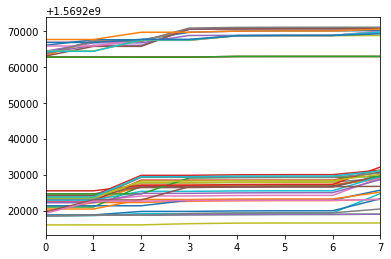

In [285]:
adf.plot(legend=None)

In [289]:
df = pd.DataFrame(res)

In [316]:
df.groupby("Flow")

KeyError: 'Flow'

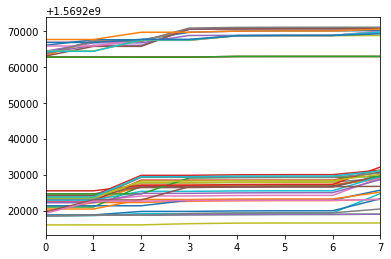

In [298]:
df.plot(legend=None)

In [300]:
import datetime

order = ['Start', 'Transfer1', 'Transfer2', 'ExecCorr', 'ExecPlots', 'StageToPetrel', 'StageImagesToPetrel', 'End']

res3 = []
for sf in succeeded_flows:
    tmp = succeeded_flows[sf]
    flow_end = None
    flow_start = float('inf')
    flow_start_time = None
    flow_steps = {}
    for x in tmp['entries']:
        action_timestamp = None
        try:
            action_timestamp = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S.%f+00:00').timestamp()
        except:
            action_timestamp = datetime.datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S+00:00').timestamp()
        if action_timestamp < flow_start:
            flow_start = action_timestamp
            flow_start_time = action_timestamp
        if x['code'] == "FlowSucceeded":
            flow_end = action_timestamp
        if x['code'] == 'ActionCompleted':
            if 'details' in x and 'state_name' in x['details']:
                action_name = x['details']['state_name']
            action_time = action_timestamp
            flow_steps.update({action_name : action_time})
            # We can pull out transfer times/size here. Do that once this works and we want to include more info.
            
    #         if 'Transfer' in action_name or 'Stage' in action_name:
    #             print(action_name)
    #             print(x['details'])
    #             break
    flow_steps.update({"Flow": sf, "Start": flow_start, "End": flow_end})
    time_res = [sf]
    for x in order:
        try:
            time_res.append(flow_steps[x])
        except:
            # Transfer1 might not be here if we have over 100 steps.
            time_res.append(flow_steps['Start'])
    res3.append(time_res)

In [324]:
adf = pd.DataFrame(res3, columns=['Flow', 'Start', 'Transfer1', 'Transfer2', 'ExecCorr', 'ExecPlots', 'StageToPetrel', 'StageImagesToPetrel', 'End'])
adf2 = pd.DataFrame(res3, columns=['Flow', 1, 2, 3, 4, 5, 6, 7, 8])

In [325]:
adf2

,Flow,1,2,3,4,5,6,7,8
0,02229ba8-23fa-45c0-9ad2-4982f7dd1b5d,1.569264e+09,1.569267e+09,1.569267e+09,1.569270e+09,1.569271e+09,1.569271e+09,1.569271e+09,1.569271e+09
1,f0ce795a-e4e4-46fd-a997-1e05df29ed42,1.569220e+09,1.569222e+09,1.569222e+09,1.569223e+09,1.569223e+09,1.569223e+09,1.569223e+09,1.569223e+09
2,44861417-0bad-4ecc-ab8c-d8f8b79786d3,1.569221e+09,1.569221e+09,1.569227e+09,1.569227e+09,1.569227e+09,1.569227e+09,1.569227e+09,1.569229e+09
3,878f060a-1a4b-400b-82c4-d06c45402052,1.569224e+09,1.569224e+09,1.569230e+09,1.569230e+09,1.569230e+09,1.569230e+09,1.569230e+09,1.569231e+09
4,5ed48889-bc13-4ee8-aead-148fd5173921,1.569264e+09,1.569267e+09,1.569267e+09,1.569269e+09,1.569269e+09,1.569269e+09,1.569269e+09,1.569269e+09
5,00ffbb60-2541-45cb-b318-d85c8b8f9e72,1.569224e+09,1.569224e+09,1.569226e+09,1.569226e+09,1.569227e+09,1.569227e+09,1.569227e+09,1.569230e+09
6,b112706d-f406-4e37-bab8-be8c5dcbd7f6,1.569267e+09,1.569267e+09,1.569267e+09,1.569267e+09,1.569269e+09,1.569269e+09,1.569269e+09,1.569270e+09
7,0062ec23-00ed-430e-a7f9-500f93d5628c,1.569223e+09,1.569223e+09,1.569228e+09,1.569228e+09,1.569228e+09,1.569228e+09,1.569228e+09,1.569229e+09
8,410836cf-e59e-413e-8346-6db1d67064c3,1.569216e+09,1.569216e+09,1.569216e+09,1.569216e+09,1.569217e+09,1.569217e+09,1.569217e+09,1.569217e+09
9,81d2f04c-cd3f-4b31-81a7-c140b7ff1b0a,1.569219e+09,1.569219e+09,1.569219e+09,1.569219e+09,1.569219e+09,1.569219e+09,1.569219e+09,1.569225e+09


In [326]:
df4=pd.melt(adf2,id_vars=['Flow'],var_name='metrics', value_name='values')
df4

,Flow,metrics,values
0,02229ba8-23fa-45c0-9ad2-4982f7dd1b5d,1,1.569264e+09
1,f0ce795a-e4e4-46fd-a997-1e05df29ed42,1,1.569220e+09
2,44861417-0bad-4ecc-ab8c-d8f8b79786d3,1,1.569221e+09
3,878f060a-1a4b-400b-82c4-d06c45402052,1,1.569224e+09
4,5ed48889-bc13-4ee8-aead-148fd5173921,1,1.569264e+09
5,00ffbb60-2541-45cb-b318-d85c8b8f9e72,1,1.569224e+09
6,b112706d-f406-4e37-bab8-be8c5dcbd7f6,1,1.569267e+09
7,0062ec23-00ed-430e-a7f9-500f93d5628c,1,1.569223e+09
8,410836cf-e59e-413e-8346-6db1d67064c3,1,1.569216e+09
9,81d2f04c-cd3f-4b31-81a7-c140b7ff1b0a,1,1.569219e+09


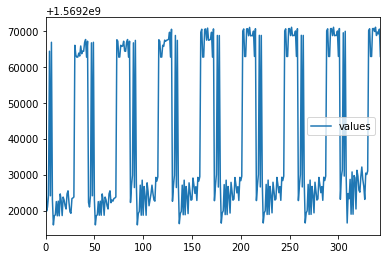

In [307]:
df2.plot(kind='line', label="Flow")

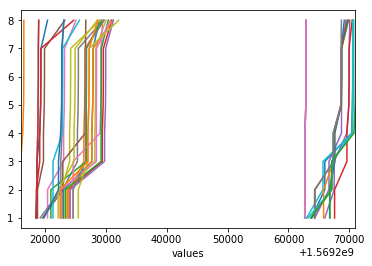

In [329]:
# df2.plot(kind='scatter', y='values', x='metrics')
fig, ax = plt.subplots()
df4.groupby("Flow").plot(x="values", y="metrics", ax=ax, legend=None)
plt.show()

In [330]:
df4.to_csv('xpcs_melt_numeric.csv')

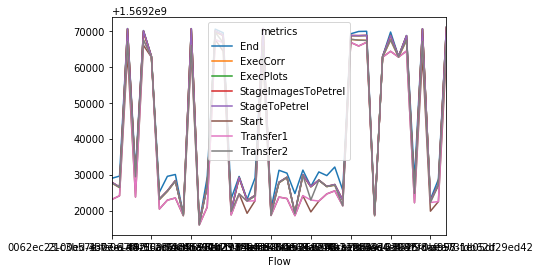

In [312]:

df3 = df2.pivot(index='Flow', columns='metrics', values='values')
# df3
df3.plot()

In [333]:
xdf = pd.read_csv('xpcs_melt_numeric.csv')

In [334]:
xdf

,Unnamed: 0,Flow,metrics,values
0,0,02229ba8-23fa-45c0-9ad2-4982f7dd1b5d,1,1.569264e+09
1,1,f0ce795a-e4e4-46fd-a997-1e05df29ed42,1,1.569220e+09
2,2,44861417-0bad-4ecc-ab8c-d8f8b79786d3,1,1.569221e+09
3,3,878f060a-1a4b-400b-82c4-d06c45402052,1,1.569224e+09
4,4,5ed48889-bc13-4ee8-aead-148fd5173921,1,1.569264e+09
5,5,00ffbb60-2541-45cb-b318-d85c8b8f9e72,1,1.569224e+09
6,6,b112706d-f406-4e37-bab8-be8c5dcbd7f6,1,1.569267e+09
7,7,0062ec23-00ed-430e-a7f9-500f93d5628c,1,1.569223e+09
8,8,410836cf-e59e-413e-8346-6db1d67064c3,1,1.569216e+09
9,9,81d2f04c-cd3f-4b31-81a7-c140b7ff1b0a,1,1.569219e+09


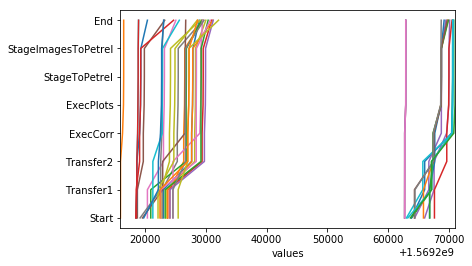

In [347]:
ticks = ['', 'Start', 'Transfer1', 'Transfer2', 'ExecCorr', 'ExecPlots', 'StageToPetrel', 'StageImagesToPetrel', 'End']

fig, ax = plt.subplots()
xdf.groupby("Flow").plot(x="values", y="metrics", ax=ax, legend=None)
ax.set_yticklabels(ticks)
plt.show()

In [385]:
adf2.to_csv('xpcs_numeric.csv')

In [386]:
all_df = pd.read_csv('xpcs_automate.csv')
xdf2 = adf2.sort_values([1])[:20]
xdf2

KeyError: '1'

In [382]:
xdf2=pd.melt(xdf2,id_vars=['Flow'],var_name='metrics', value_name='values')

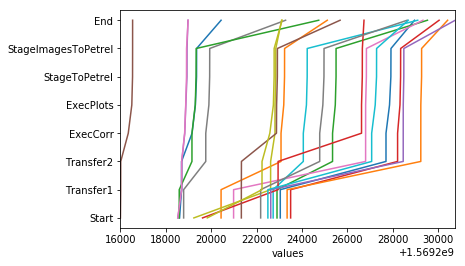

In [383]:
ticks = ['', 'Start', 'Transfer1', 'Transfer2', 'ExecCorr', 'ExecPlots', 'StageToPetrel', 'StageImagesToPetrel', 'End']

fig, ax = plt.subplots()
xdf2.groupby("Flow").plot(x="values", y="metrics", ax=ax, legend=None)
ax.set_yticklabels(ticks)
plt.show()